<a href="https://colab.research.google.com/github/peterliujpdev/MNIST-Digit-Recognizer/blob/main/MNIST_Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Math Intuition



1. Pytorch structure

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 1. 卷积层 (Convolutional Layers)
        # 输入通道 1 (黑白图), 输出通道 32 (提取32种特征), 卷积核 3x3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        # 输入通道 32, 输出通道 64
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)

        # 2. 全连接层 (Fully Connected Layers)
        # 这里需要算一下维度，或者先跑一次报错看看具体数字，通常是 64 * 5 * 5 或类似
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10) # 最后输出 10 个数字 (0-9)

    def forward(self, x):
        # 第一层卷积 + 激活函数(ReLU) + 池化(Pooling)
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # 图片变小一半

        # 第二层卷积
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # 图片又变小一半

        # 展平 (Flatten): 把立体的数据拍扁成一维向量，准备喂给全连接层
        x = torch.flatten(x, 1)

        # 全连接分类
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        # 输出 Logits (未归一化的概率)
        return x

# 实例化模型
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ==========================================
# 第一步：准备数据 (Data Preparation)
# ==========================================
# 定义一个变换：把图片变成 Tensor (矩阵)，并归一化 (让数值在 0-1 之间，方便计算)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# 下载训练集 (60,000 张)
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# 下载测试集 (10,000 张)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 建立加载器 (Batch Size = 64 意味着我们要一次并行计算 64 张图，利用矩阵加速)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

# ==========================================
# 第二步：搭建模型 (Model Architecture)
# ==========================================
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 卷积层：提取特征 (这就是那个点积操作！)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # 池化层：降维 (选最大值)
        self.pool = nn.MaxPool2d(2, 2)
        # 全连接层：分类
        # 28x28 的图经过两次池化(除以2)，变成 7x7。64是通道数。
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10) # 输出 10 个数字的概率

    def forward(self, x):
        # Layer 1
        x = self.pool(torch.relu(self.conv1(x)))
        # Layer 2
        x = self.pool(torch.relu(self.conv2(x)))
        # Flatten (拉平成一维向量)
        x = x.view(-1, 64 * 7 * 7)
        # Fully Connected
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有 GPU 就用 GPU
model = SimpleCNN().to(device)

# ==========================================
# 第三步：定义优化目标 (Math Setup)
# ==========================================
# 损失函数 (Loss Function): 交叉熵损失 (CrossEntropy)，用来衡量“猜错了多少”
criterion = nn.CrossEntropyLoss()
# 优化器 (Optimizer): 随机梯度下降 (SGD) 的进化版 Adam
# lr=0.001 是学习率 (Learning Rate)，也就是梯度下降的步长
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ==========================================
# 第四步：开始训练 (The Training Loop)
# ==========================================
print("🚀 开始训练... (可能会花几分钟)")

num_epochs = 3 # 训练轮数：把所有数据看 3 遍

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # 1. 梯度清零 (Reset Gradients) - 就像数学求导前要把之前的计算清空
        optimizer.zero_grad()

        # 2. 前向传播 (Forward Pass) - 算出预测值
        outputs = model(images)

        # 3. 计算误差 (Calculate Loss)
        loss = criterion(outputs, labels)

        # 4. 反向传播 (Backward Pass) - 这里的核心就是 Chain Rule (链式法则)！
        # 它计算出每个参数对误差的贡献(梯度)
        loss.backward()

        # 5. 更新权重 (Update Weights) - 沿着梯度的反方向走一步
        optimizer.step()

        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print("✅ 训练完成！")

# ==========================================
# 第五步：测试准确率 (Evaluation)
# ==========================================
model.eval() # 切换到测试模式
correct = 0
total = 0
with torch.no_grad(): # 测试不需要算梯度，节省内存
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) # 选概率最大的那个数字
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'🎉 在 10,000 张测试图片上的准确率: {100 * correct / total:.2f}%')

100%|██████████| 9.91M/9.91M [00:00<00:00, 57.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.66MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.02MB/s]


🚀 开始训练... (可能会花几分钟)
Epoch [1/3], Step [100/938], Loss: 0.1576
Epoch [1/3], Step [200/938], Loss: 0.0410
Epoch [1/3], Step [300/938], Loss: 0.0848
Epoch [1/3], Step [400/938], Loss: 0.0462
Epoch [1/3], Step [500/938], Loss: 0.0256
Epoch [1/3], Step [600/938], Loss: 0.0712
Epoch [1/3], Step [700/938], Loss: 0.0113
Epoch [1/3], Step [800/938], Loss: 0.0187
Epoch [1/3], Step [900/938], Loss: 0.0153
Epoch [2/3], Step [100/938], Loss: 0.0414
Epoch [2/3], Step [200/938], Loss: 0.0114
Epoch [2/3], Step [300/938], Loss: 0.0323
Epoch [2/3], Step [400/938], Loss: 0.0078
Epoch [2/3], Step [500/938], Loss: 0.0157
Epoch [2/3], Step [600/938], Loss: 0.0457
Epoch [2/3], Step [700/938], Loss: 0.1176
Epoch [2/3], Step [800/938], Loss: 0.0237
Epoch [2/3], Step [900/938], Loss: 0.0191
Epoch [3/3], Step [100/938], Loss: 0.0051
Epoch [3/3], Step [200/938], Loss: 0.1334
Epoch [3/3], Step [300/938], Loss: 0.0163
Epoch [3/3], Step [400/938], Loss: 0.0148
Epoch [3/3], Step [500/938], Loss: 0.0030
Epoch [3/3], S

请点击下方按钮上传一张手写数字图片 (白纸黑字)...


Saving image6.jpg to image6.jpg


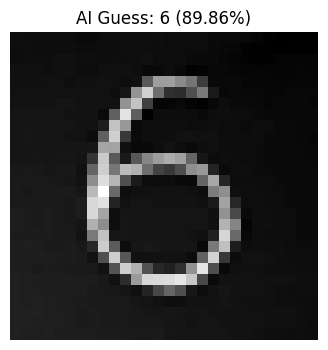

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from google.colab import files
import torch.nn.functional as F

def predict_my_image():
    # 1. 弹出上传按钮
    print("请点击下方按钮上传一张手写数字图片 (白纸黑字)...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        # 2. 打开图片
        image = Image.open(filename)

        # 3. 关键步骤：图片预处理 (要把图片变得和 MNIST 数据集一样)
        # 3.1 转为灰度图 (RGB -> Gray)
        img_gray = image.convert('L')

        # 3.2 颜色反转！(重要：因为 MNIST 是黑底白字，而我们平时写字是白底黑字)
        # 如果你不反转，模型会把白色背景当成笔画，结果就会全错
        img_inverted = ImageOps.invert(img_gray)

        # 3.3 调整大小为 28x28
        img_resized = img_inverted.resize((28, 28))

        # 3.4 转为 Tensor 并增加维度 (变成 [1, 1, 28, 28])
        img_tensor = transform(img_resized).unsqueeze(0).to(device)

        # 4. 让模型预测
        model.eval() # 切换到评估模式
        with torch.no_grad():
            output = model(img_tensor)
            # 计算概率 (Softmax)
            probabilities = F.softmax(output, dim=1)
            prediction = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0][prediction].item() * 100

        # 5. 画出来看看
        plt.figure(figsize=(4, 4))
        plt.imshow(img_resized, cmap='gray')
        plt.title(f"AI Guess: {prediction} ({confidence:.2f}%)")
        plt.axis('off')
        plt.show()

# 运行互动函数
predict_my_image()